<a href="https://colab.research.google.com/github/Zhou198/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')
basedir = "/content/drive/MyDrive/NLP/"

!nvidia-smi

Mounted at /content/drive
Fri Feb 16 14:56:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------

# Load Modules

In [105]:
!pip install accelerate -U
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f7e56976bb7886a6db98263de07eb909e642b6858e20e2ac295eff1c6039bbb8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from transformers import AutoModel, AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Utilis

In [4]:
def npTorchCGPU_manula_seed(device, myseed=1234):
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    if device != "cpu":
        torch.cuda.manual_seed(myseed)

# Tasks

## Text Classification

In [ ]:
from transformers import AutoModelForSequenceClassification

### Load Datasets

In [ ]:
def tokenize_dataset(dataset):
    return tokenizer(dataset["text"], truncation=True)

In [ ]:
mydata = load_dataset("dair-ai/emotion")
num_labels = len(np.unique(mydata["train"]["label"]))

tokenized_datasets = mydata.map(tokenize_dataset, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = tokenizer(mydata["train"]["text"][:3], padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs)

print(f"inputs = {inputs}\noutputs = {outputs}")

inputs = {'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102],
        [  101, 10047,  9775,  1037,  3371,  2000,  2695,  1045,  2514, 20505,
          3308,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
outputs = SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0247,  0.0382, -0.0119, -0.0828,  0.0110,  0.0382],
        [ 0.0273,  0.0383, -0.0049

### Fine-tuning

In [ ]:
training_args = TrainingArguments(
    output_dir=f"{basedir}/results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    logging_dir=f"{basedir}/logs"
)

mytrainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer)

In [ ]:
mytrainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.549194
2,No log,0.264410
3,No log,0.223814


TrainOutput(global_step=375, training_loss=0.5670075276692709, metrics={'train_runtime': 235.7191, 'train_samples_per_second': 203.632, 'train_steps_per_second': 1.591, 'total_flos': 748096761378816.0, 'train_loss': 0.5670075276692709, 'epoch': 3.0})

### Prediction

In [ ]:
test_result = mytrainer.predict(tokenized_datasets["test"])
test_result

PredictionOutput(predictions=array([[ 4.276497  , -0.5622775 , -1.4437035 , -0.44548923, -1.2106957 ,
        -1.3231283 ],
       [ 4.388058  , -0.96319544, -1.3785189 , -0.59489036, -1.0821667 ,
        -1.1482    ],
       [ 4.3640084 , -1.002495  , -1.3999224 , -0.99853605, -0.8171334 ,
        -0.95676684],
       ...,
       [-0.8583079 ,  4.8101144 , -0.06063928, -1.1036084 , -1.314213  ,
        -0.8168227 ],
       [-0.75287116,  4.635616  , -0.41671416, -1.0901785 , -1.0710588 ,
        -0.684662  ],
       [-0.7698281 , -1.1776756 , -1.0019193 , -1.1316811 ,  2.173919  ,
         2.1390722 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 4]), metrics={'test_loss': 0.22172601521015167, 'test_runtime': 3.3213, 'test_samples_per_second': 602.181, 'test_steps_per_second': 4.817})

In [ ]:
pred = test_result.predictions.argmax(-1)
np.mean(pred == test_result.label_ids)

0.917

## Summarization

In [5]:
from transformers import AutoModelForSeq2SeqLM

### Load Datasets

In [8]:
mydata = load_dataset("samsum")
mydata

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

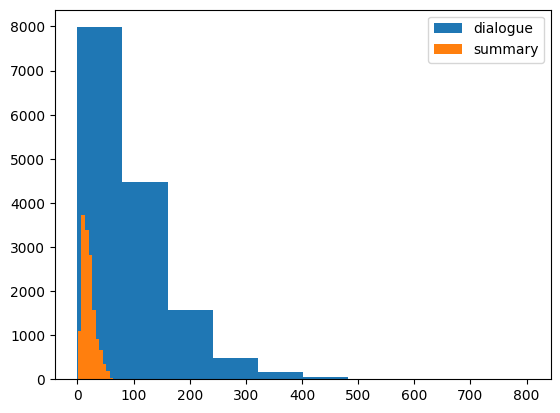

In [9]:
# check the sequence length to adequately set the max_lenght in tokenizer()
mydata_train_summary = np.array([[len(data["dialogue"].split()), len(data["summary"].split())] for data in mydata["train"]])

plt.hist(mydata_train_summary[:, 0], label="dialogue")
plt.hist(mydata_train_summary[:, 1], label="summary")
plt.legend()

### Fine-tuning

In [10]:
checkpoint = ["google-t5/t5-small", "facebook/bart-base"][-1]
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [11]:
# logically, this function should be defined after you observe the keys output from tokenizer() applied on the mydata
def tokenize(batch, max_len_en=512, max_len_de=128):
    tokendized_batch = tokenizer(batch["dialogue"], max_length=max_len_en, truncation=True)
    tokendized_batch["labels"] = tokenizer(batch["summary"], max_length=max_len_de, truncation=True)["input_ids"]

    return tokendized_batch

In [12]:
# simultaneously tokenize a batch of sub-data in the original mydata
tokenized_dataset = mydata.map(tokenize, batched=True)

# delete useless data information: 'id', 'dialogue', 'summary'
tokenized_dataset = tokenized_dataset.remove_columns(mydata["train"].column_names)
tokenized_dataset

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [13]:
for key, val in tokenized_dataset["train"][:2].items():
    print(f"--{key}: {val}")

--input_ids: [[0, 10127, 5219, 35, 38, 17241, 1437, 15269, 4, 1832, 47, 236, 103, 116, 50121, 50118, 39237, 35, 9136, 328, 50121, 50118, 10127, 5219, 35, 38, 581, 836, 47, 3859, 48433, 2], [0, 673, 31332, 493, 35, 3394, 32, 47, 3434, 13, 11, 42, 729, 116, 1437, 50121, 50118, 33453, 8538, 35, 12993, 25, 460, 4, 50121, 50118, 673, 31332, 493, 35, 1464, 350, 12846, 50121, 50118, 33453, 8538, 35, 2860, 2]]
--attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
--labels: [[0, 10127, 5219, 17241, 15269, 8, 40, 836, 6509, 103, 3859, 4, 2], [0, 673, 31332, 493, 8, 20544, 32, 3434, 13, 19561, 11, 42, 729, 4, 1437, 2]]


In [14]:
# for efficently and dynamically padding
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [15]:
# data_collator requires a list of dict
inputs = data_collator([tokenized_dataset["train"][i] for i in range(2)])
with torch.no_grad():
    outputs = model(**inputs)
outputs.logits

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[[33.9104,  6.0766, 17.2567,  ...,  6.6644,  6.4543,  2.5844],
         [ 7.8567, -2.2038, 13.0703,  ..., -1.6107, -1.5877, -1.3851],
         [ 0.3880, -0.1795,  9.1637,  ...,  2.0656,  1.9801,  2.1516],
         ...,
         [-2.0966, -2.7672, 10.5321,  ..., -2.9314, -2.9194, -1.3329],
         [-3.6056, -3.4430,  5.7905,  ..., -3.3843, -3.4921, -2.9883],
         [-2.9177, -2.3025,  7.2112,  ..., -1.7296, -2.0533, -2.0149]],

        [[34.2056,  6.5078, 17.1634,  ...,  7.3893,  7.2975,  2.8263],
         [ 6.8863, -2.1168, 10.6629,  ..., -1.0640, -0.7982, -0.4983],
         [-0.2908,  0.1929,  7.2798,  ...,  2.0701,  0.5026,  1.2065],
         ...,
         [-5.7131, -4.3474,  6.9236,  ..., -3.4156, -4.0472, -2.1507],
         [-6.3865, -3.7926,  4.3494,  ..., -3.5411, -3.4277, -2.3434],
         [-7.1900, -1.4001,  4.4726,  ...,  1.9755,  2.6671, -0.5043]]])

In [16]:
# gradient_accumulation_steps is critical since we are deploying such large LM, i.e., BART, on the this small T4 GPU; otherwise your training fails
# here the gradient is essentially updated after seeing "every" per_device_train_batch_size * gradient_accumulation_steps = 64 sequences
training_args = TrainingArguments(
    output_dir=f"{basedir}/results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    gradient_accumulation_steps=16,
    logging_dir=f"{basedir}/logs")

npTorchCGPU_manula_seed(device)
mytrainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer)

In [17]:
mytrainer.train()

Epoch,Training Loss,Validation Loss
0,No log,1.594258
1,No log,1.550151
2,1.851400,1.539259


TrainOutput(global_step=690, training_loss=1.8047757356063179, metrics={'train_runtime': 1823.4752, 'train_samples_per_second': 24.237, 'train_steps_per_second': 0.378, 'total_flos': 7344089860423680.0, 'train_loss': 1.8047757356063179, 'epoch': 3.0})

In [19]:
mytrainer.save_model(f"{basedir}/bart_samsum")

### Prediction

In [76]:
# ground truth
for i in range(2):
    print(f"Dialogue {i}:\n{mydata['test']['dialogue'][i]}\n**summary:\n{mydata['test']['summary'][i]}\n")

Dialogue 0:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
**summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Dialogue 1:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)
**summary:
Eric and Rob are

In [50]:
# different from "text classification", the prediction/inference in "generative" tasks needs to use either model.generate() or pipeline()
generation_para = {"min_length": 10, "max_length": 100, "length_penalty": 2.0, "num_beams": 4} # beamed search
npTorchCGPU_manula_seed(device)
test_inputs = tokenizer(mydata["test"]["dialogue"][:2], padding=True, truncation=True, return_tensors="pt").to(device)
test_ouputs = model.generate(**test_inputs, **generation_para)

test_ouputs

tensor([[    2,     0,   725, 25984,    64,    75,   465, 16666,    18,   346,
             4,   264, 25199,  6045,    94,    86,    51,    58,    23,     5,
          2221,   561,     4,     2],
        [    2,     0, 24375,  3829,  3005,    18,  1413,    12,   658,     4,
          3005,    40,  1183,    24,   122,     4,  1437,     2,     1,     1,
             1,     1,     1,     1]], device='cuda:0')

In [56]:
test_pred_ids = test_ouputs.cpu().tolist()
test_pred_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in test_pred_ids]
[tokenizer.convert_tokens_to_string(tokens) for tokens in test_pred_tokens ]

["</s><s>Hannah can't find Betty's number. She texted Larry last time they were at the park together.</s>",
 "</s><s>Eric likes Rob's stand-up. Rob will watch it now. </s><pad><pad><pad><pad><pad><pad>"]

In [78]:
from transformers import pipeline

In [90]:
dialog_summary = pipeline("summarization", model=model, tokenizer=tokenizer, framework="pt", device=device)

In [92]:
beam_gen = dialog_summary(mydata["test"]["dialogue"][:2], **generation_para)
beam_gen

[{'summary_text': "Hannah can't find Betty's number. She texted Larry last time they were at the park together."},
 {'summary_text': "Eric likes Rob's stand-up. Rob will watch it now. "}]

In [115]:
# top-p sampling
topp_gen = dialog_summary(mydata["test"][:2]["dialogue"], do_sample=True, top_p=0.9999999, temperature=0.7)
topp_gen

[{'summary_text': "Hannah can't find Betty's number. Amanda will text Larry."},
 {'summary_text': 'Eric likes the train part. Rob will watch some of his stand-ups on youtube.'}]

#### scores

In [140]:
rouge_gen = load_metric("rouge")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [141]:
predictions = [ele["summary_text"] for ele in topp_gen]
references = [[ele] for ele in mydata['test']['summary'][:2]]

rouge_score = rouge_gen.compute(predictions=predictions, references=references)
for key, val in rouge_score.items():
    print(f"{key}: {val}")

rouge1: AggregateScore(low=Score(precision=0.4, recall=0.4375, fmeasure=0.4444444444444445), mid=Score(precision=0.5181818181818182, recall=0.46875, fmeasure=0.4814814814814815), high=Score(precision=0.6363636363636364, recall=0.5, fmeasure=0.5185185185185185))
rouge2: AggregateScore(low=Score(precision=0.07142857142857142, recall=0.09090909090909091, fmeasure=0.08), mid=Score(precision=0.13571428571428573, recall=0.11212121212121212, fmeasure=0.12), high=Score(precision=0.2, recall=0.13333333333333333, fmeasure=0.16))
rougeL: AggregateScore(low=Score(precision=0.4, recall=0.375, fmeasure=0.4444444444444444), mid=Score(precision=0.4727272727272727, recall=0.4375, fmeasure=0.4444444444444444), high=Score(precision=0.5454545454545454, recall=0.5, fmeasure=0.4444444444444445))
rougeLsum: AggregateScore(low=Score(precision=0.4, recall=0.375, fmeasure=0.4444444444444444), mid=Score(precision=0.4727272727272727, recall=0.4375, fmeasure=0.4444444444444444), high=Score(precision=0.545454545454